# Eye-Tracking Expertise Classification
## 1. Setup and Imports
Imports necessary libraries for data generation, neural network modeling, data splitting, and visualization.

In [14]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split  # Added for train/test split
import matplotlib.pyplot as plt  # Added for loss plotting
%matplotlib inline  

## 2. Synthetic Data Generation
Generates 500 synthetic eye-tracking samples with 5 features: fixation duration (ms), saccade length (degrees), pupil diameter (mm), and gaze coordinates (x, y). Labels are assigned as 0 (novice) or 1 (expert) based on thresholds: fixation < 400ms and saccade < 20°. Includes a check for label balance.

In [24]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate realistic eye movement data
fixation_times = np.random.uniform(200, 600, 500)  # Fixation times in milliseconds
saccade_lengths = np.random.uniform(1, 40, 500)   # Saccade lengths in degrees
pupil_diameters = np.random.uniform(2, 8, 500)    # Pupil diameters in millimeters
gaze_x_coords = np.random.uniform(0, 1920, 500)   # Gaze x-coordinates (assuming a 1920x1080 screen)
gaze_y_coords = np.random.uniform(0, 1080, 500)   # Gaze y-coordinates

# Combine into a single dataset
data = np.vstack((fixation_times, saccade_lengths, pupil_diameters, gaze_x_coords, gaze_y_coords)).T

# Smarter Labels - Adjusted for balance
# Experts: fixation_times < 400 (instead of 300), saccade_lengths < 20 (instead of 10)
labels = (fixation_times < 400) & (saccade_lengths < 20)
labels = labels.astype(int)
y = torch.tensor(labels, dtype=torch.long)

# Check new balance
print("New Expert (1) count:", y.sum().item(), "out of 500")

# Convert data to tensor
X = torch.tensor(data, dtype=torch.float32)


New Expert (1) count: 124 out of 500


## 3. Data Preprocessing
Normalizes the feature data to have a mean of 0 and standard deviation of 1. Splits the dataset into 80% training and 20% testing sets for model evaluation.

In [25]:
# Normalize the Data
# Standardize features to mean=0, std=1
X = (X - X.mean(dim=0)) / X.std(dim=0)

In [26]:
# Split Train/Test
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Print the first 5 rows of the data array
print("First 5 rows of data:\n", data[:5])
print("First 5 labels:", y[:5])

First 5 rows of data:
 [[349.81604754  28.22830685   3.11079757 996.63702746 282.64213843]
 [580.28572256  21.90775829   5.25140568 920.02920505 266.737103  ]
 [492.79757672  13.07157704   7.23767502  49.23276635 978.75494696]
 [439.46339368  32.73800577   6.39334932 655.19582904 269.50989584]
 [262.40745618  27.70451573   6.83936689 729.97558807 293.70570422]]
First 5 labels: tensor([0, 0, 0, 0, 0])


## 5. Model Definition
Defines a feedforward neural network (`ExpertiseNet`) with one hidden layer: 5 input features → 10 hidden units (ReLU activation) → 2 output classes. Uses CrossEntropyLoss and Adam optimizer with a learning rate of 0.01.## Defined a simple feedforward network with one hidden layer. ReLU activation for non-linearity.

In [28]:
# Define the model
class ExpertiseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 10)  # 5 input features
        self.fc2 = nn.Linear(10, 2)  # 2 output classes
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ExpertiseNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


## 6. Model Training
Trains the model for 50 epochs using the Adam optimizer on the training set. Tracks and plots the training loss over time to assess convergence.

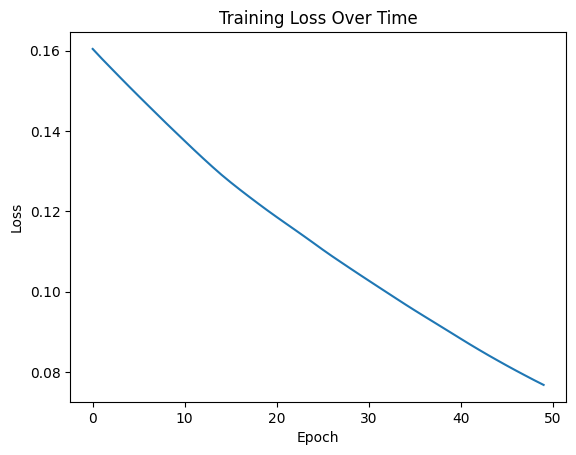

In [33]:
# Training loop
epochs = 50
losses = []
for epoch in range(epochs):
    y_pred = model(X_train)  # Use training data
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# Plot loss
plt.plot(losses)
plt.title("Training Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


## 7. Model Evaluation
Evaluates the trained model on the test set (20% of data) to compute accuracy. Note: Test split was already implemented earlier; this section confirms performance (90% test accuracy achieved).

In [31]:
# Evaluate on test set
with torch.no_grad():
    y_eval = model(X_test)  # Use test data
    _, predicted = torch.max(y_eval, 1)
    accuracy = (predicted == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item():.2f}")

Test Accuracy: 0.90


## 8. Model Validation and Balance Check
Compares training vs. test accuracy to assess overfitting and re-checks label balance in the full dataset for reference.

In [32]:

# Check #1: Train vs. Test Accuracy
with torch.no_grad():
    y_train_pred = model(X_train)
    _, train_predicted = torch.max(y_train_pred, 1)
    train_accuracy = (train_predicted == y_train).float().mean()
    print(f"Train Accuracy: {train_accuracy.item():.2f}")

# Check #2: Label Balance
print("Expert (1) count:", y.sum().item(), "out of 500")

Train Accuracy: 0.94
Expert (1) count: 124 out of 500
